In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")

In [4]:
datasets =[
    {'name': 'Self_instruct', 'path': '../data/cleaned_self_instruction_instruction_embedding.pth'},
    {'name': 'Alpaca_gpt4', 'path': '../data/cleaned_alpaca_gpt4_data_instruction_embedding.pth'},
    {'name': 'Dolly', 'path': '../data/cleaned_databricks_dolly_15k_instruction_embedding.pth'},
    {'name': 'ShareGPT', 'path': '../data/cleaned_ShareGPT_V3_unfiltered_cleaned_split_no_imsorry_instruction_embedding.pth'},
    {'name': 'WizardLM_alpaca', 'path': '../data/cleaned_alpaca_evol_instruct_70k_instruction_embedding.pth'},
]

data = []
for item in datasets:
    data += torch.load(item['path'])

/tmp/ipykernel_3670/1555296056.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data += torch.load(item['path'])


In [10]:
quality_greedy_cluster_centers_values_ = torch.topk(torch.tensor(log_file['quality'][overall_top12k_indices]), 6000).values
diversity_greedy_cluster_centers_values_ = torch.topk(torch.tensor(log_file['representation'][overall_top12k_indices]), 6000).values

# Analysis of Diversity and Quality Contribution

In [126]:
def analysis(name):
    for i in range(12, 13):
        log_file = torch.load(f'../pool_evolve/ap_logs/{name}/{i}.pth')
        # dict_keys(['representation', 'scaled_representation_scores', 'all_candidate_index', 'quality', 'scaled_quality_scores', 'overall_scores'])
        
        overall_scores = torch.tensor((1+log_file['scaled_representation_scores'])) * torch.tensor((1+log_file['scaled_quality_scores']))
        if overall_scores.shape[0] < 12000:
            continue
        
        print(f"STEP {i}")
        
        top_overall_indices = torch.topk(overall_scores, overall_scores.shape[0]).indices
        top_quality_indices = torch.topk(torch.tensor(log_file['scaled_quality_scores']), overall_scores.shape[0]).indices
        top_diversity_indices = torch.topk(torch.tensor(log_file['scaled_representation_scores']), overall_scores.shape[0]).indices
    
        print("Full Data Correlation")
        print(spearmanr(overall_scores, log_file['representation']))
        print(spearmanr(overall_scores, log_file['quality']))
        print("--"*10)
    
        sub_quality = log_file['scaled_quality_scores'][top_overall_indices]
        # selected_flags = [1 if idx in top_quality_indices[:6000] else 0 for idx in top_overall_indices]
        selected_flag = np.array([1 if i < 6000 else 0 for i in range(sub_quality.shape[0])])
        print(spearmanr(sub_quality, torch.tensor(selected_flag)))
        print("--"*10)

        sub_diversity = log_file['scaled_representation_scores'][top_overall_indices]
        selected_flag = np.array([1 if i < 6000 else 0 for i in range(sub_quality.shape[0])])
        print(spearmanr(sub_diversity, torch.tensor(selected_flag)))
        
        print("**"*20)
        print("**"*20)
    
        print("Top 12k Data Correlation")
        print(spearmanr(overall_scores[top_overall_indices[:12000]], log_file['scaled_quality_scores'][top_overall_indices[:12000]]))
        print(spearmanr(overall_scores[top_overall_indices[:12000]], log_file['scaled_representation_scores'][top_overall_indices[:12000]]))
        print("--"*10)
        
        sub_quality = log_file['scaled_quality_scores'][top_overall_indices[:12000]]
        selected_flag = np.array([1 if i < 6000 else 0 for i in range(sub_quality.shape[0])])
        print(spearmanr(sub_quality, torch.tensor(selected_flag)))
        print("--"*10)
    
        sub_diversity = log_file['scaled_representation_scores'][top_overall_indices[:12000]]
        selected_flag = np.array([1 if i < 6000 else 0 for i in range(sub_quality.shape[0])])
        print(spearmanr(sub_diversity, torch.tensor(selected_flag)))
        
        print("**"*20)
        print("**"*20)
    
        print("Top 6k Data Correlation")
        print(spearmanr(overall_scores[top_overall_indices[:6000]], log_file['scaled_quality_scores'][top_overall_indices[:6000]]))
        print(spearmanr(overall_scores[top_overall_indices[:6000]], log_file['scaled_representation_scores'][top_overall_indices[:6000]]))
        print("--"*10)
        
        # sub_quality = log_file['scaled_quality_scores'][top_overall_indices[:6000]]
        # selected_flag = np.array([1 if i < 6000 else 0 for i in range(sub_quality.shape[0])])
        # print(spearmanr(sub_quality, torch.tensor(selected_flag)))
        # print("--"*10)
    
        # sub_diversity = log_file['scaled_representation_scores'][top_overall_indices[:6000]]
        # selected_flag = np.array([1 if i < 6000 else 0 for i in range(sub_quality.shape[0])])
        # print(spearmanr(sub_diversity, torch.tensor(selected_flag)))
        
        print("**"*20)
        print("**"*20)
    
        overall_top12k_indices = torch.topk(torch.tensor(overall_scores), 12000).indices
        quality_greedy_cluster_centers_indices_ = torch.topk(torch.tensor(log_file['quality'][overall_top12k_indices]), 6000).indices
        diversity_greedy_cluster_centers_indices_ = torch.topk(torch.tensor(log_file['representation'][overall_top12k_indices]), 6000).indices
        
        plt.figure(figsize=(32,6))
        
        plt.subplot(1, 8, 1)
        plt.hist(log_file['scaled_quality_scores'][overall_top12k_indices][quality_greedy_cluster_centers_indices_], label='Quality-QG', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 2)
        plt.hist(log_file['scaled_quality_scores'][overall_top12k_indices][diversity_greedy_cluster_centers_indices_], label='Quality-DG', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 3)
        plt.hist(log_file['scaled_quality_scores'][overall_top12k_indices][:6000], label='Quality-PIBE', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 4)
        plt.hist(log_file['scaled_quality_scores'][overall_top12k_indices], label='Quality-Top12k', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 5)
        plt.hist(log_file['scaled_representation_scores'][overall_top12k_indices][quality_greedy_cluster_centers_indices_], label='Diversity-QG', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 6)
        plt.hist(log_file['scaled_representation_scores'][overall_top12k_indices][diversity_greedy_cluster_centers_indices_], label='Diversity-DG', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 7)
        plt.hist(log_file['scaled_representation_scores'][overall_top12k_indices][:6000], label='Diversity-PIBE', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.subplot(1, 8, 8)
        plt.hist(log_file['scaled_representation_scores'][overall_top12k_indices], label='Diversity-Top12k', bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.legend()
        
        plt.legend()
        plt.show()

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.6079202714728937), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8460804741256356), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5731729792473432), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6700264166882453), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.41727238083522483), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8062690048575978), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.3650726253327639), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.7402603793248923), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Corr

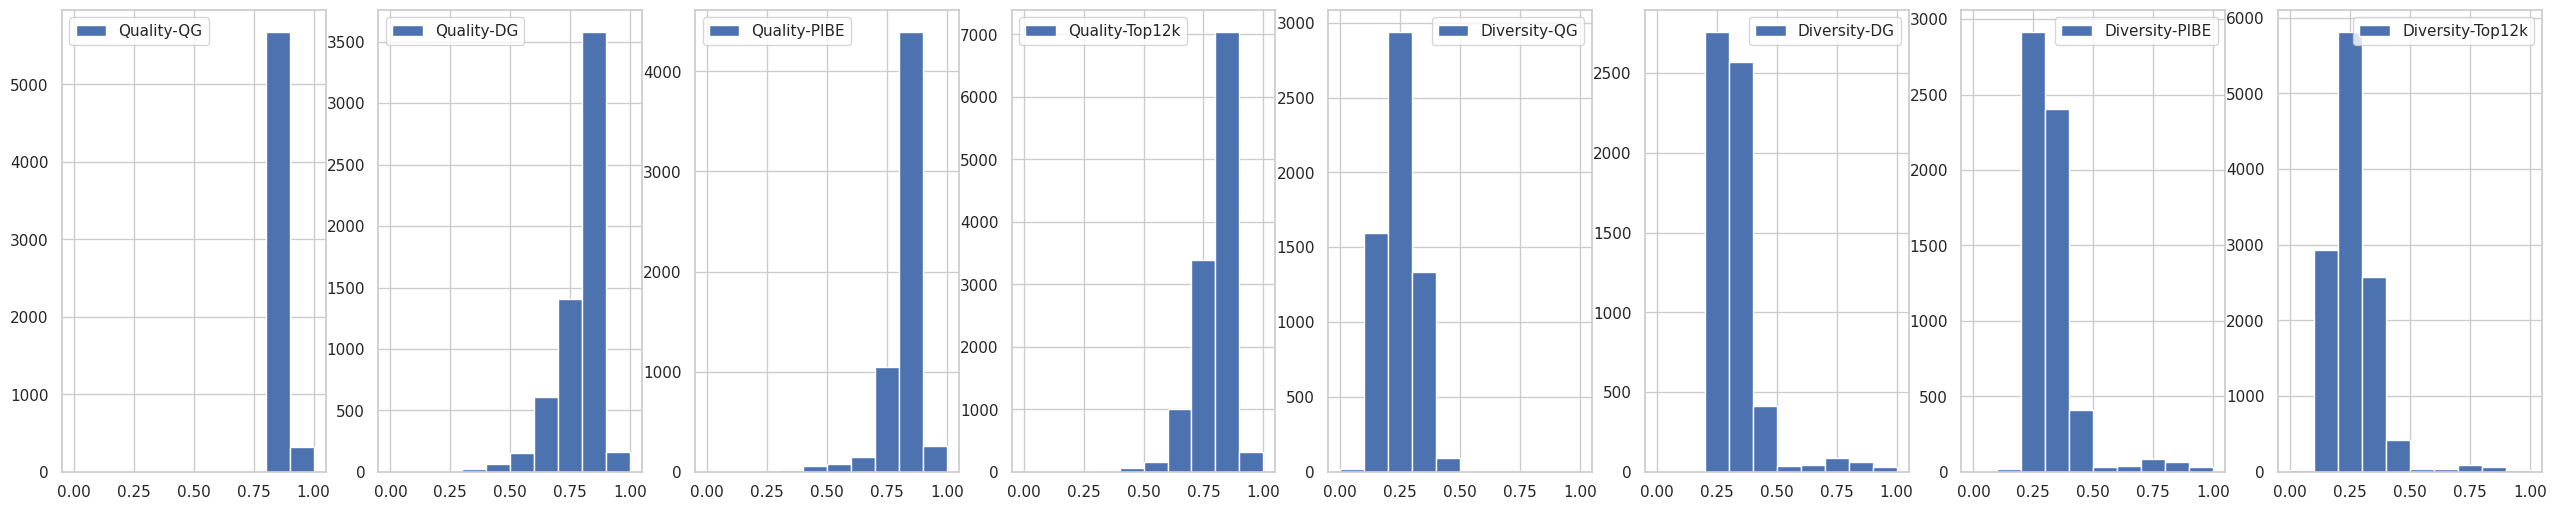

In [141]:
analysis("1205_cleaned_euclidean_multiply_alpha_0.3_lamb_0.9_gamma_1.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5848827527211065), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8817388794179425), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6420018052332348), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6370115147485288), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.5426669260324092), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7837443339741053), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5104170438917828), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.7016731980072461), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Corre

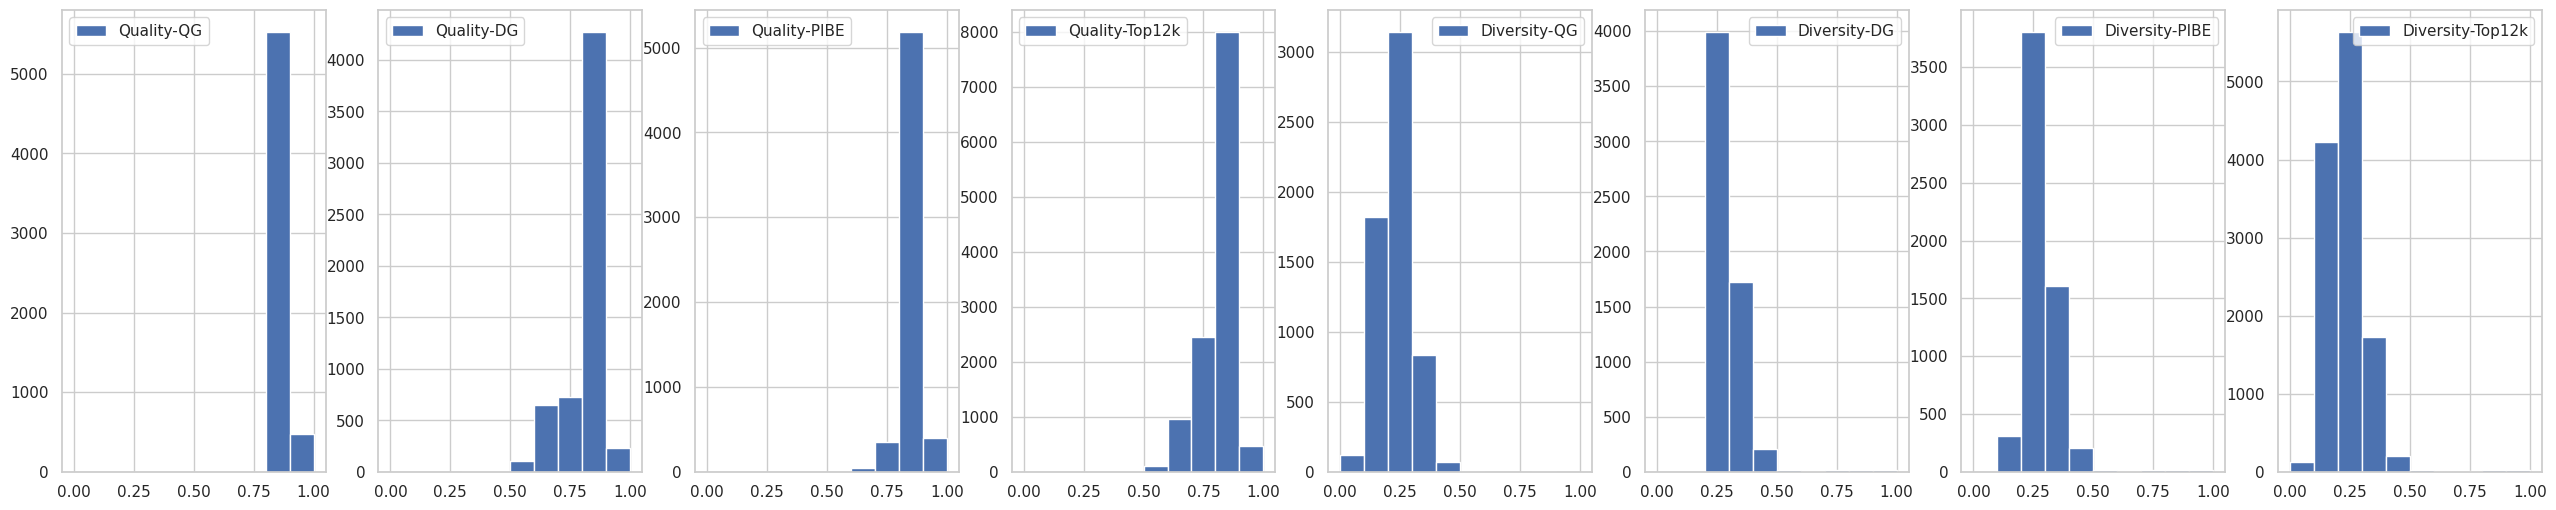

In [164]:
analysis("1205_cleaned_euclidean_multiply_alpha_0.3_lamb_0.9_gamma_2.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5504743173331716), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8934082648556518), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6569324613570648), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6104639361168857), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.5840166739931713), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7584106976007858), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5467570095614761), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.674858645787186), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Correl

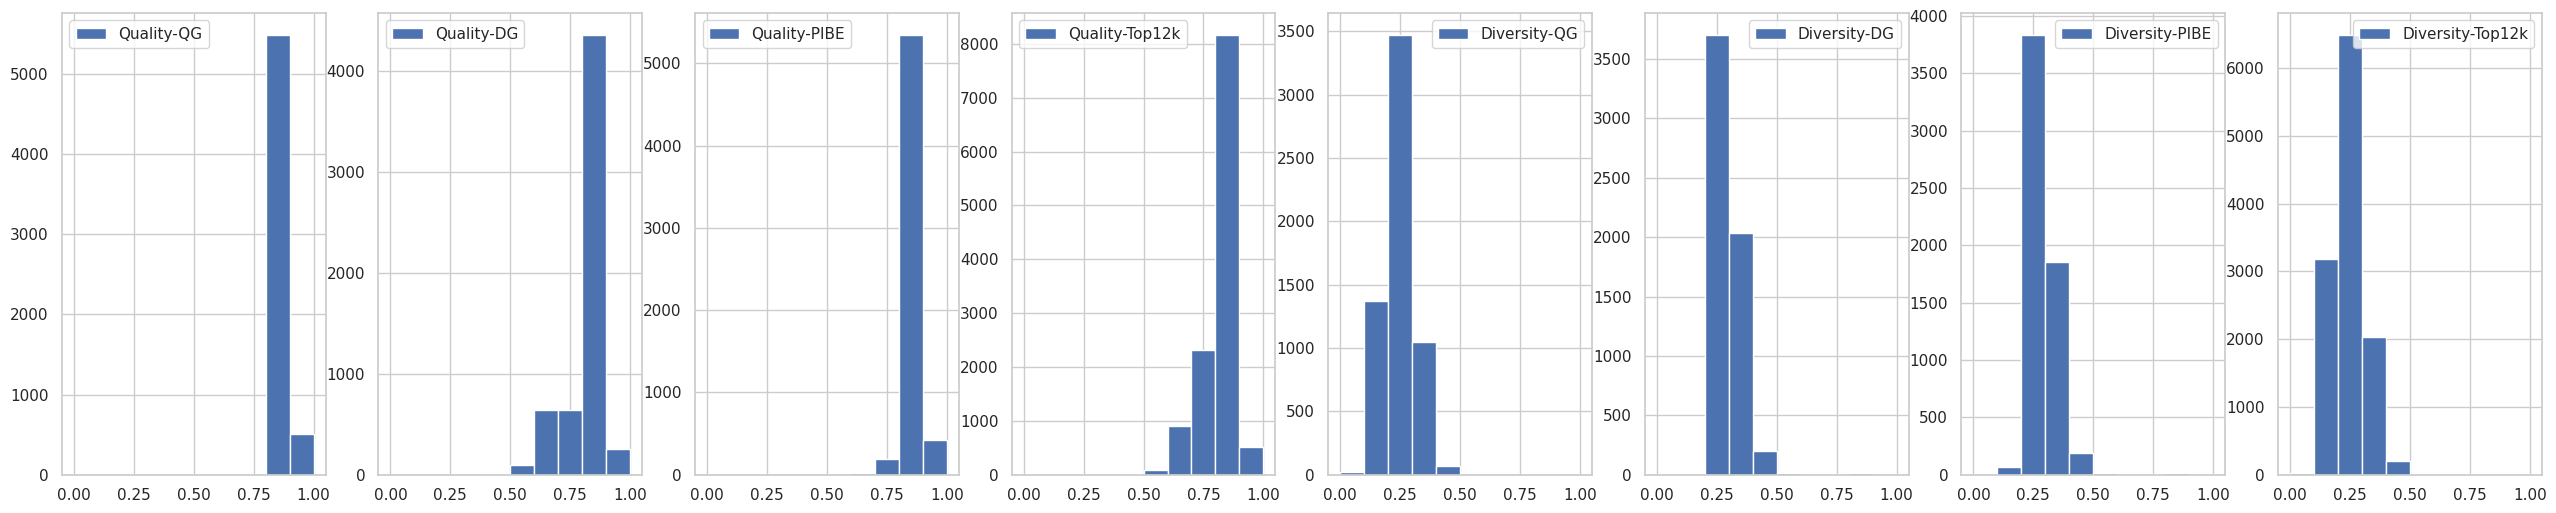

In [172]:
analysis("1217_cleaned_5sets_euclidean_multiply_alpha_0.3_lamb_0.9_gamma_3")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5852750652629825), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8649966082751618), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6088051827895326), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6522174528381474), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.476879146332494), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7951875291081466), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.44039451151313574), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.7232632835604823), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Corre

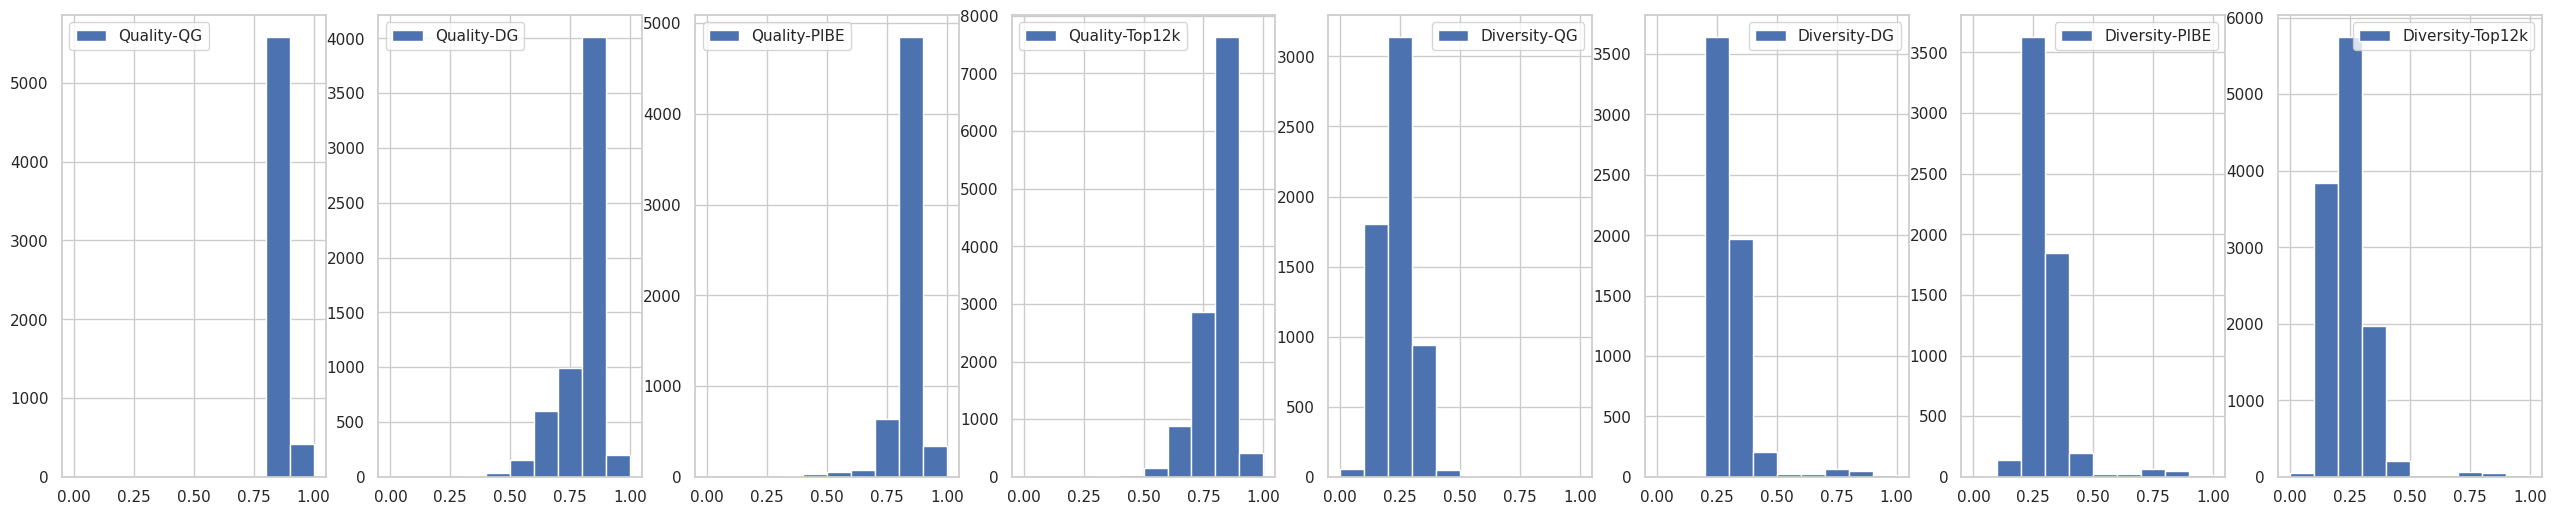

In [142]:
analysis("1209_cleaned_euclidean_addition_alpha_0.3_lamb_0.9_gamma_1.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5597249238543426), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8877191274629808), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6538608698494607), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6157072907968372), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.5718723787213359), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7678341127528157), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.54177005036899), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6814613437665392), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Correla

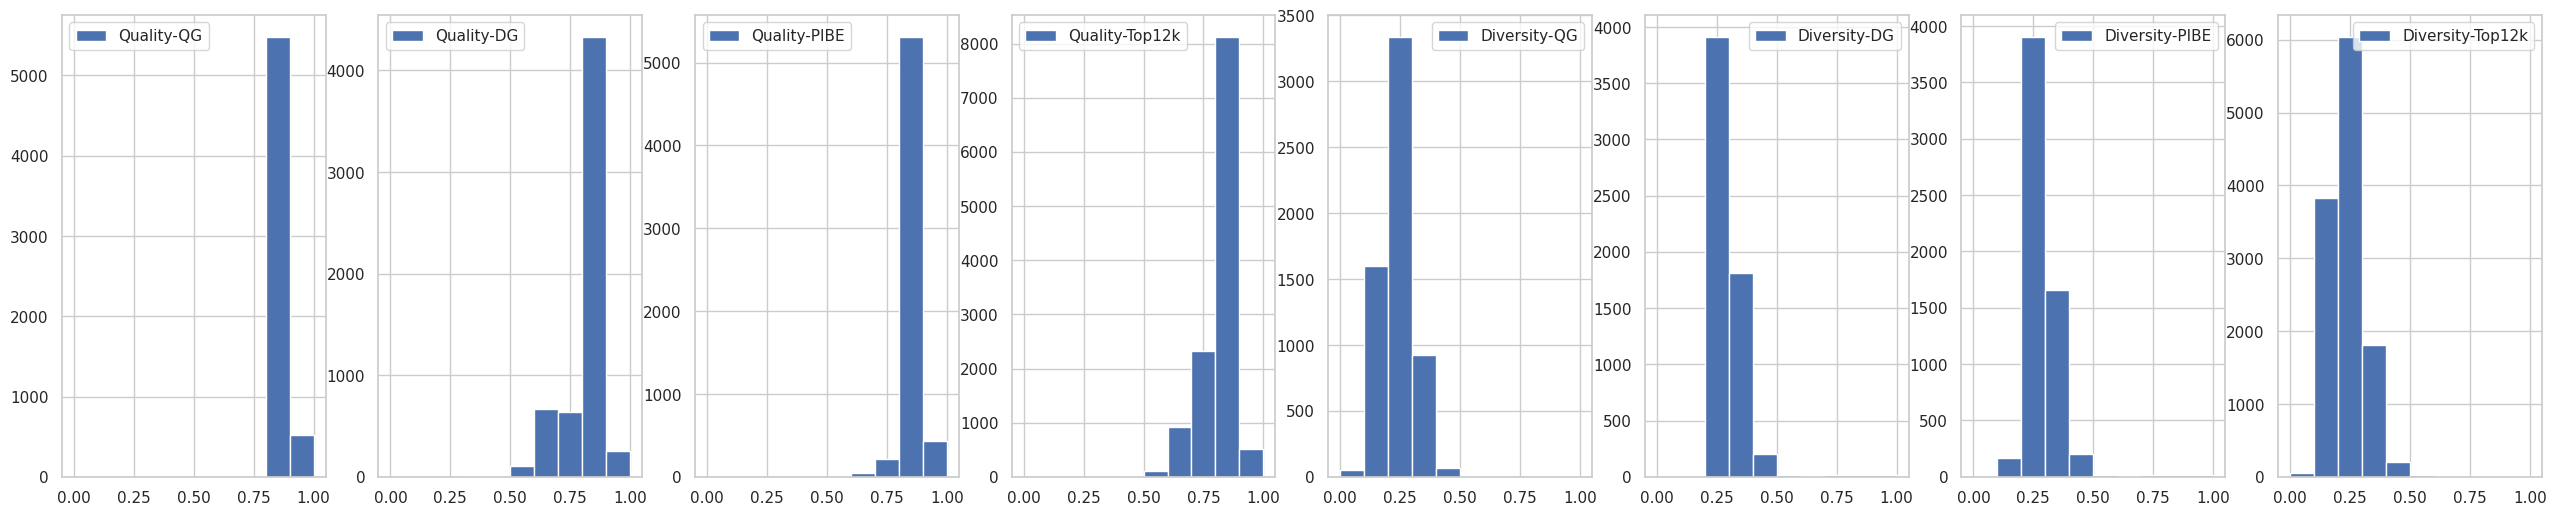

In [170]:
analysis("1209_cleaned_euclidean_addition_alpha_0.3_lamb_0.9_gamma_2.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5313993654310807), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8944726985216377), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6630029730798226), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5858068379619057), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.6015080964410284), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7356184788871172), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5658346351351629), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6470788841914985), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Corre

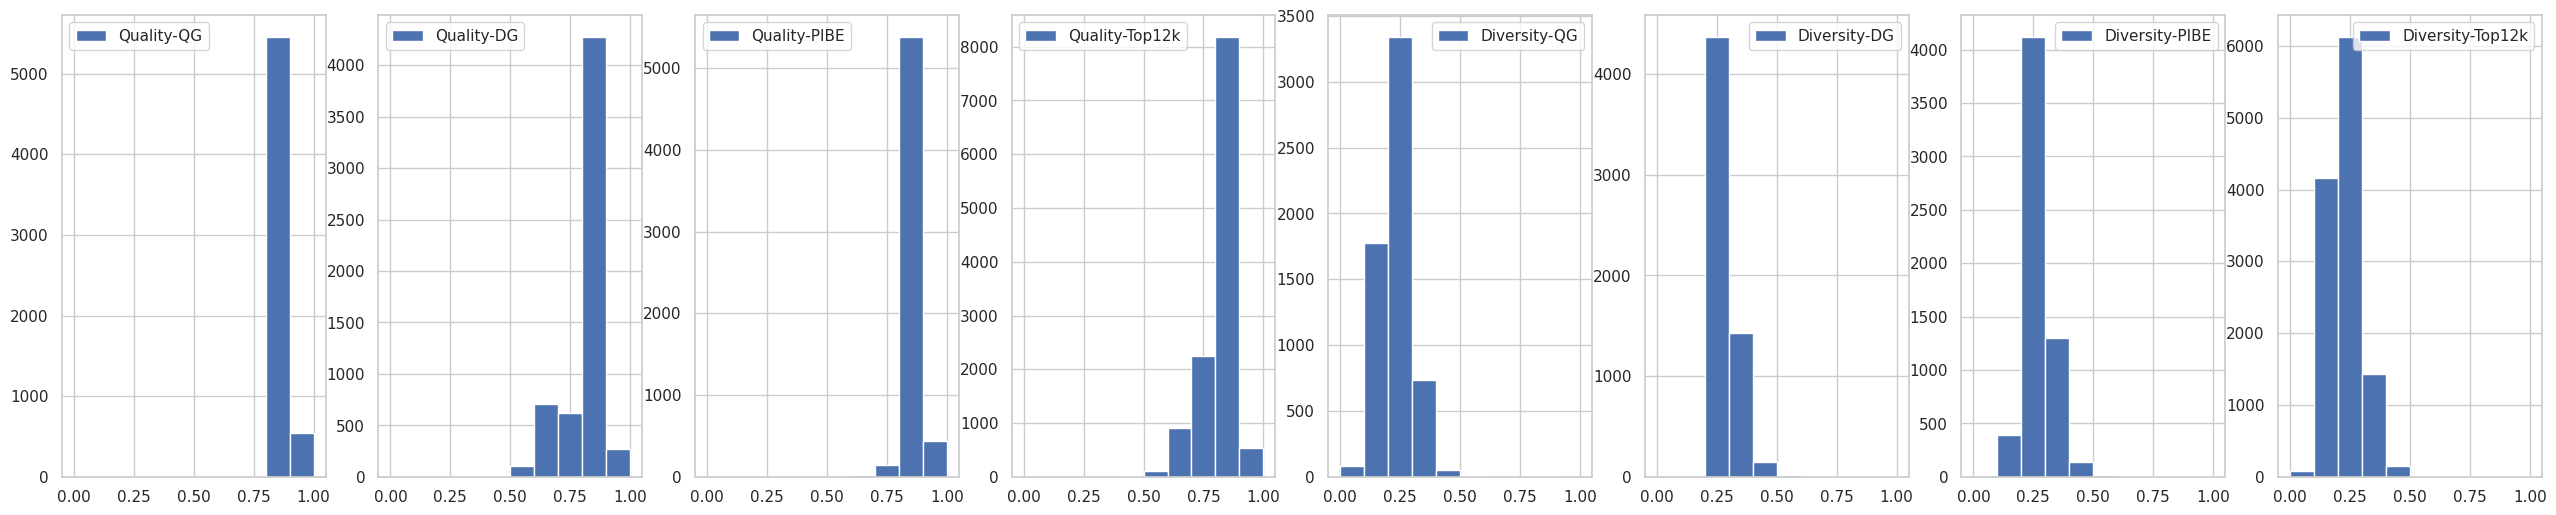

In [174]:
analysis("1220_cleaned_5sets_euclidean_addition_alpha_0.3_lamb_0.9_gamma_3")

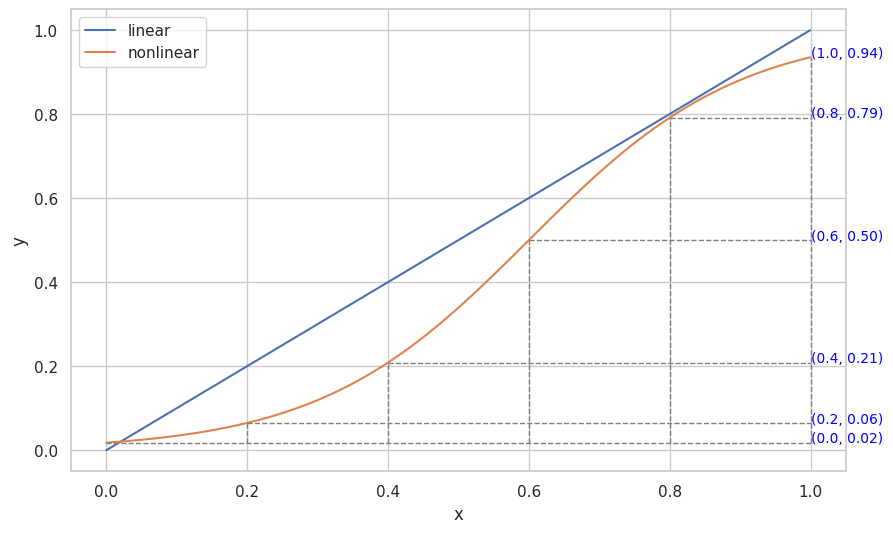

In [144]:
import math as m
import seaborn as sns
import pandas as pd

def sigmoid_fn(x):
    return 1 / (1+m.exp(-x))

def nonlinear(x, ratio_lower=0.3, ratio_upper=0.9):
    mul_coe = 4 / (ratio_upper - ratio_lower)
    sub_coe = 2 / mul_coe + ratio_lower
    return sigmoid_fn((x - sub_coe)*mul_coe)

x = []
x1 = []
x2 = []
for i in range(1000):
    x.append(i/1000)
    x1.append(x[-1])
    x2.append((nonlinear(x[-1], ratio_upper=0.9)))

linear = {
    'x': x,
    'y': x1,
}

sigmoid = {
    'x': x,
    'y': x2,
}

plt.figure(figsize=(10,6))
sns.set(style="whitegrid")  # 设置图表风格
df = pd.DataFrame(linear)
sns.lineplot(df, x='x', y='y', label='linear')

df = pd.DataFrame(sigmoid)
sns.lineplot(df, x='x', y='y', label='nonlinear')


critical_points = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
for point in critical_points:
    # 获取对应sigmoid值
    y_value = nonlinear(point, ratio_upper=0.9)
    # 添加横线
    plt.hlines(y=y_value, xmin=point, xmax=1, color='gray', linestyle='--', linewidth=1)
    # 添加坐标标注
    plt.text(1, y_value, f"({point:.1f}, {y_value:.2f})", fontsize=10, color='blue')

plt.plot([1, 1], [nonlinear(0), nonlinear(1, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)
# plt.plot([0.9, 0.9], [nonlinear(0), nonlinear(0.9, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)
plt.plot([0.8, 0.8], [nonlinear(0), nonlinear(0.8, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)
plt.plot([0.6, 0.6], [nonlinear(0), nonlinear(0.6, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)
plt.plot([0.4, 0.4], [nonlinear(0), nonlinear(0.4, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)
plt.plot([0.2, 0.2], [nonlinear(0), nonlinear(0.2, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)
plt.plot([0.0, 0.0], [nonlinear(0), nonlinear(0.0, ratio_upper=0.9)], color='gray', linestyle='--', linewidth=1)

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5256011077737737), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9142413902920087), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6267363501187755), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6602867053784718), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.5336846613311435), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8285078574078898), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.4414307590248843), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.7698741181136226), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Corre

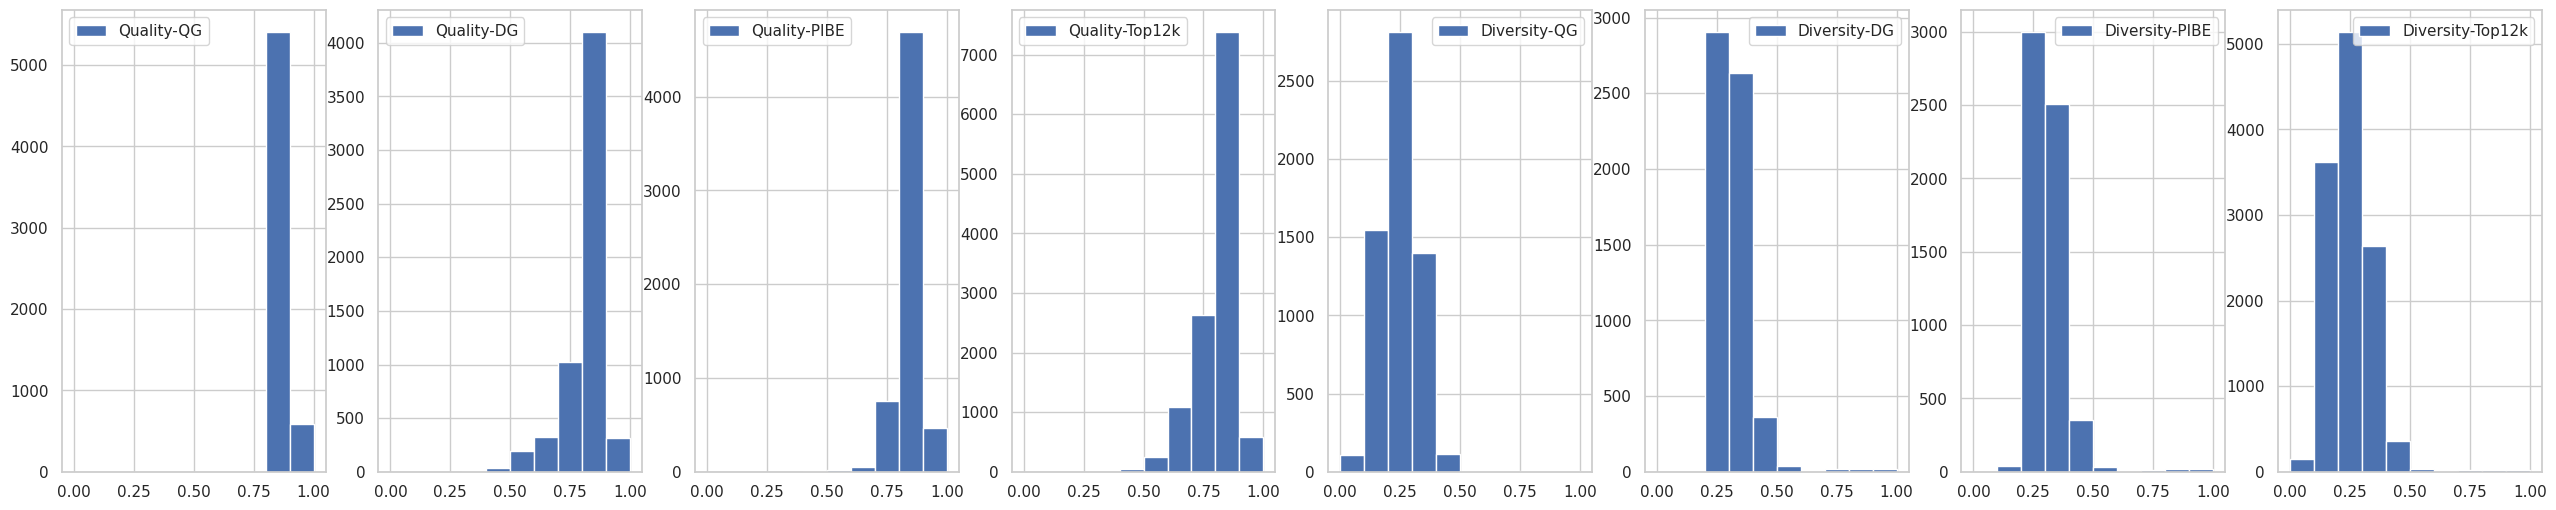

In [162]:
analysis("1223_cleaned_5sets_euclidean_nonlinear_v4_0.90_alpha_0.3_lamb_0.9_gamma_1.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5281223755382672), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9165694254887796), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6331126855247122), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6575824173645175), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.549284529751976), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8241867527813259), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.4598970668864215), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.766721424770248), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Correla

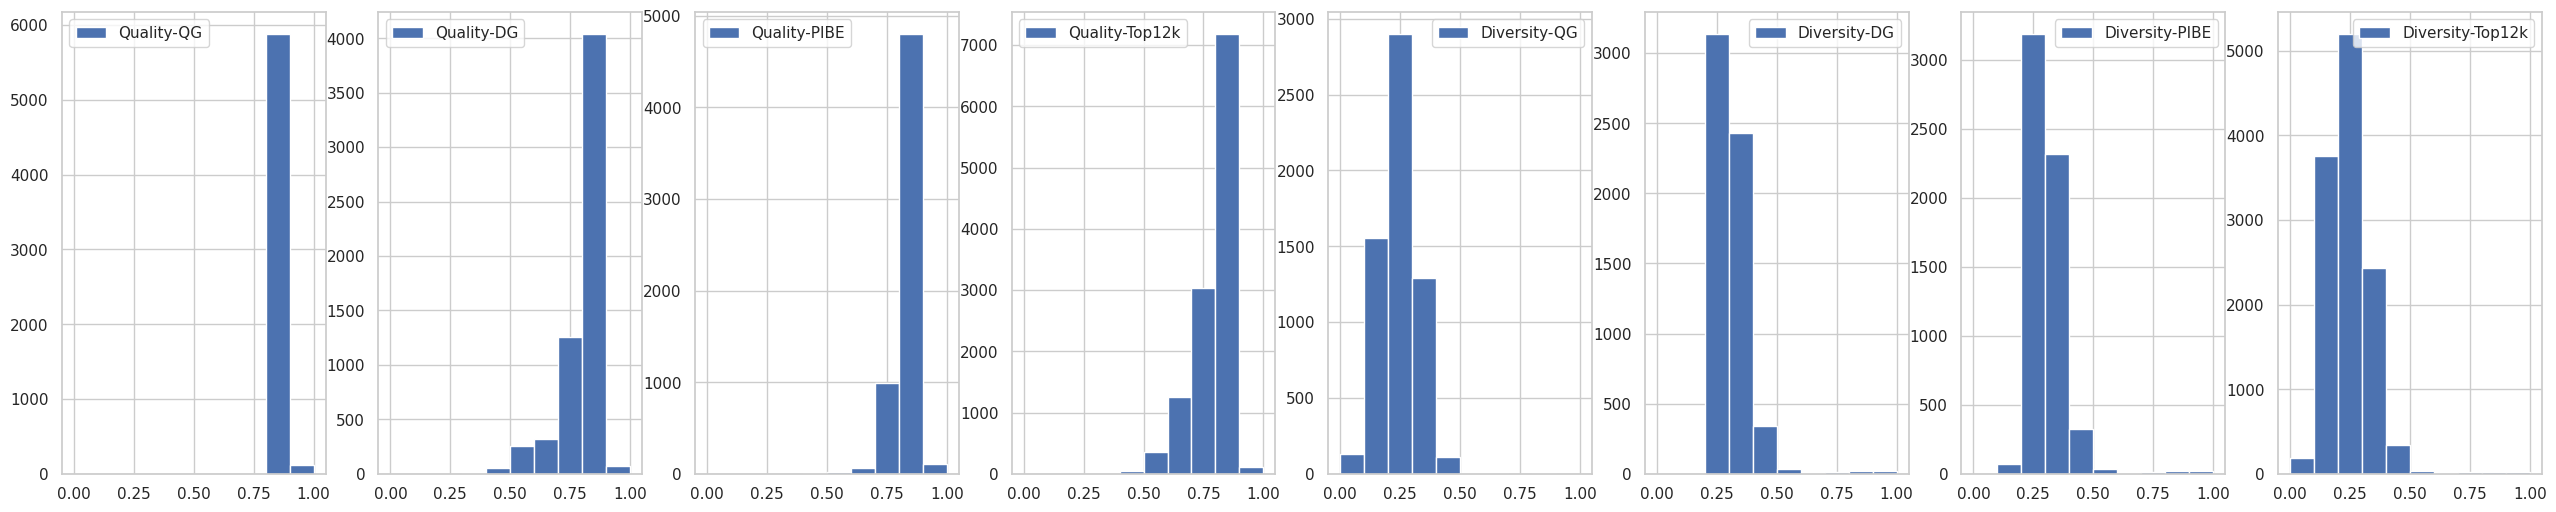

In [165]:
analysis("1223_cleaned_5sets_euclidean_nonlinear_v4_0.95_alpha_0.3_lamb_0.9_gamma_1.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.4883869426226808), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9411278393873788), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6895184167415384), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5815960201523207), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.7473138307105126), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7290512511824828), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6210305719869268), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6987028512426333), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Corre

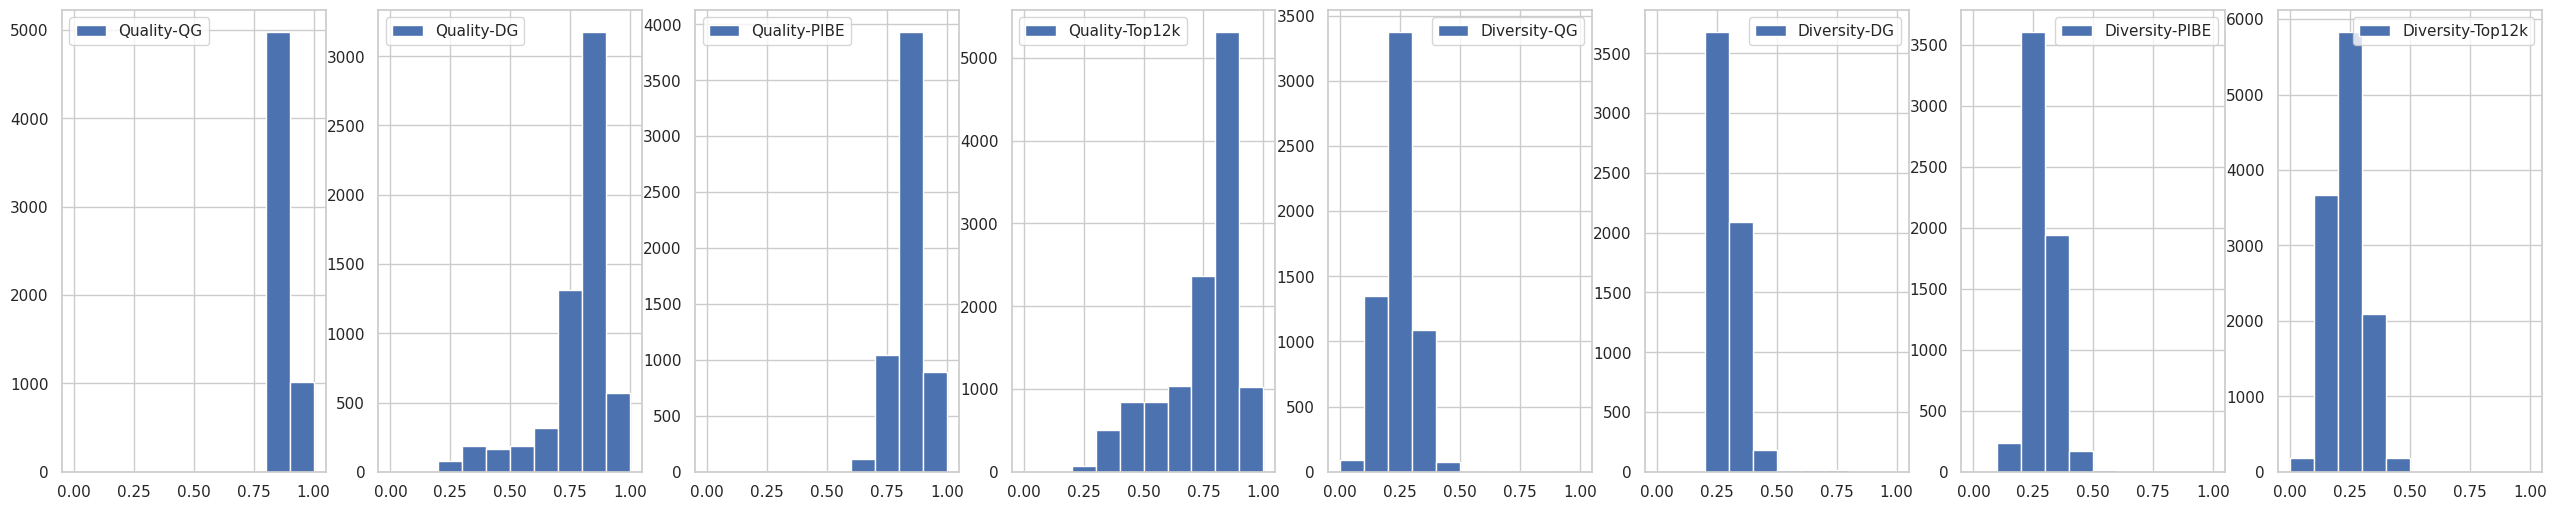

In [166]:
analysis("1223_cleaned_5sets_euclidean_nonlinear_v4_0.90_alpha_0.3_lamb_0.9_gamma_2.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.48378203404155845), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.941544366137676), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6929276035256818), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5742454139476418), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.753475501489413), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7223901706149524), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.63124067474534), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6909702312339672), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Correlat

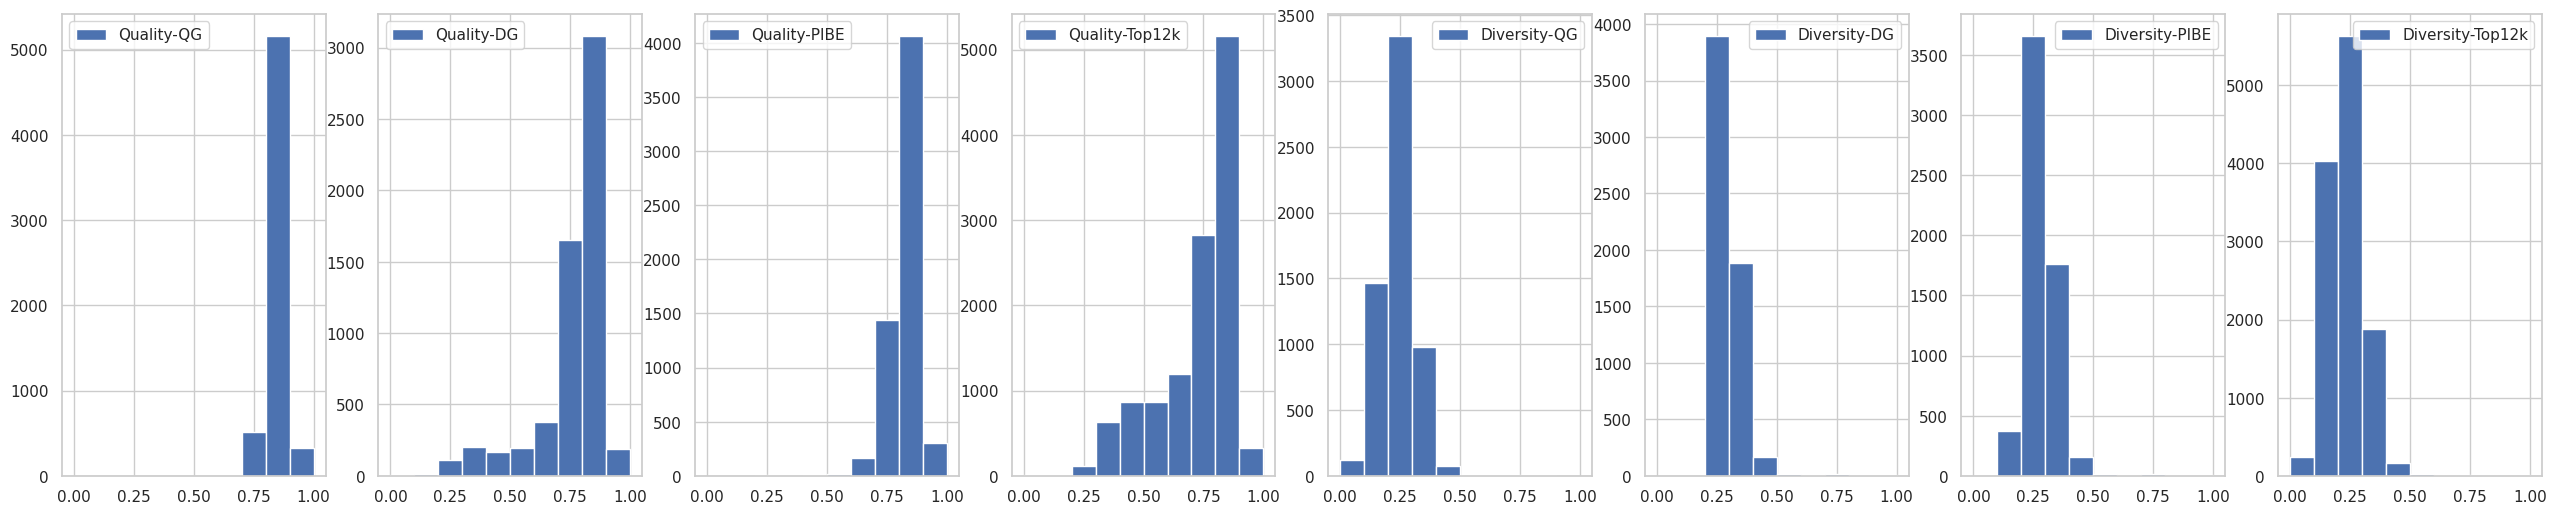

In [167]:
analysis("1223_cleaned_5sets_euclidean_nonlinear_v4_0.95_alpha_0.3_lamb_0.9_gamma_2.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5027914897192154), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.935079612252794), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6761991444794363), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.602673163396223), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.7088863862075443), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7586669763433773), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5811723299896207), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.7240781176077979), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Correla

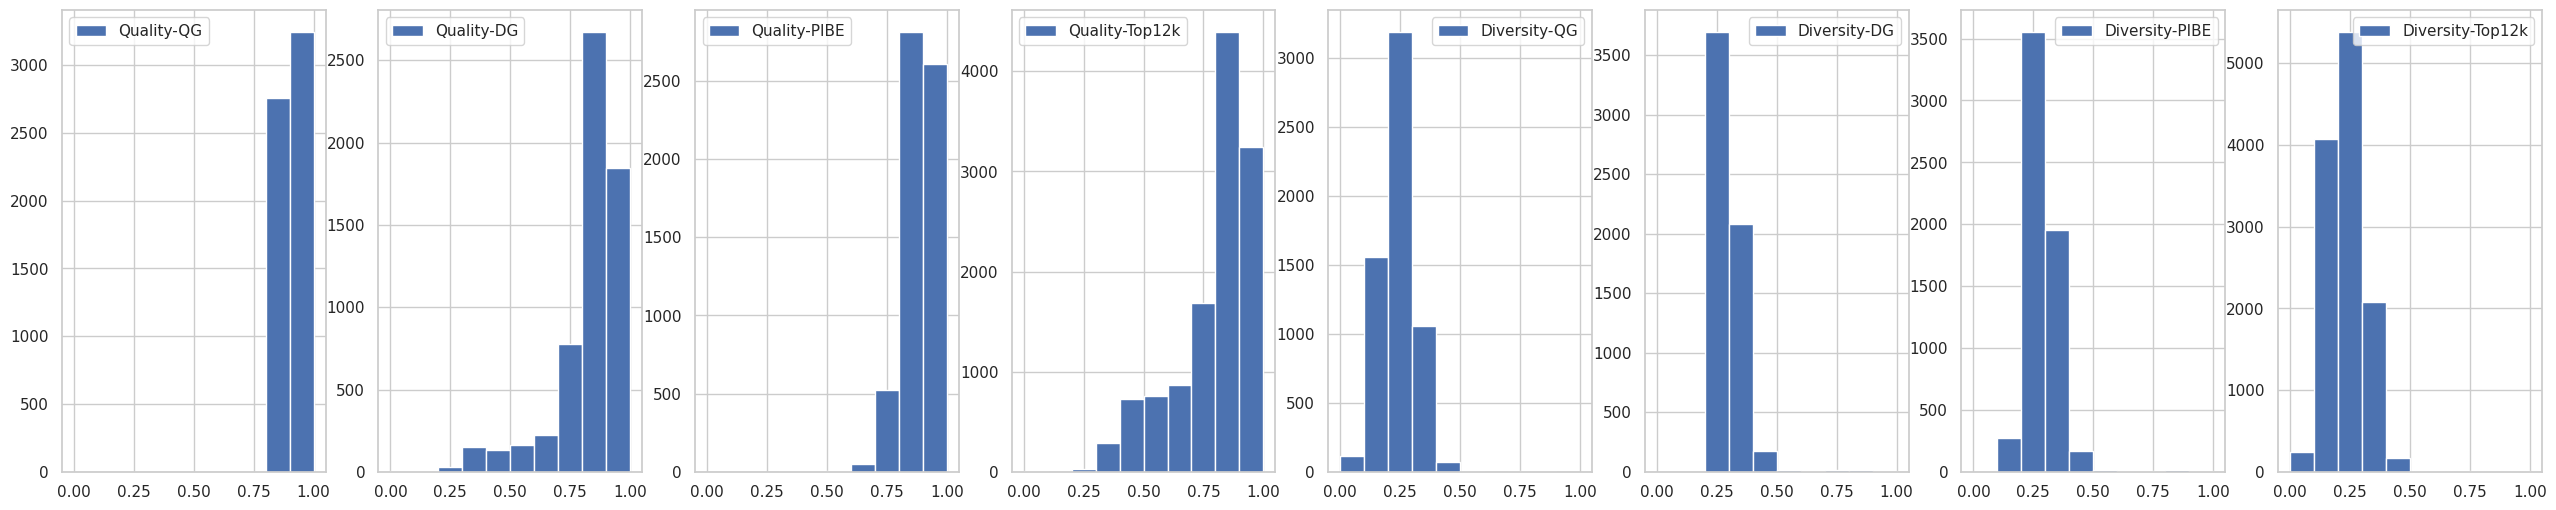

In [168]:
analysis("1223_cleaned_5sets_euclidean_nonlinear_v4_0.80_alpha_0.3_lamb_0.9_gamma_2.0")

STEP 12
Full Data Correlation
SignificanceResult(statistic=np.float64(0.5265289516744311), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9232837437100151), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.6508320422315539), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.628033345501514), pvalue=np.float64(0.0))
****************************************
****************************************
Top 12k Data Correlation
SignificanceResult(statistic=np.float64(0.6397754998456632), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.7896101162826729), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.5052312356433928), pvalue=np.float64(0.0))
--------------------
SignificanceResult(statistic=np.float64(0.7472884166450376), pvalue=np.float64(0.0))
****************************************
****************************************
Top 6k Data Correl

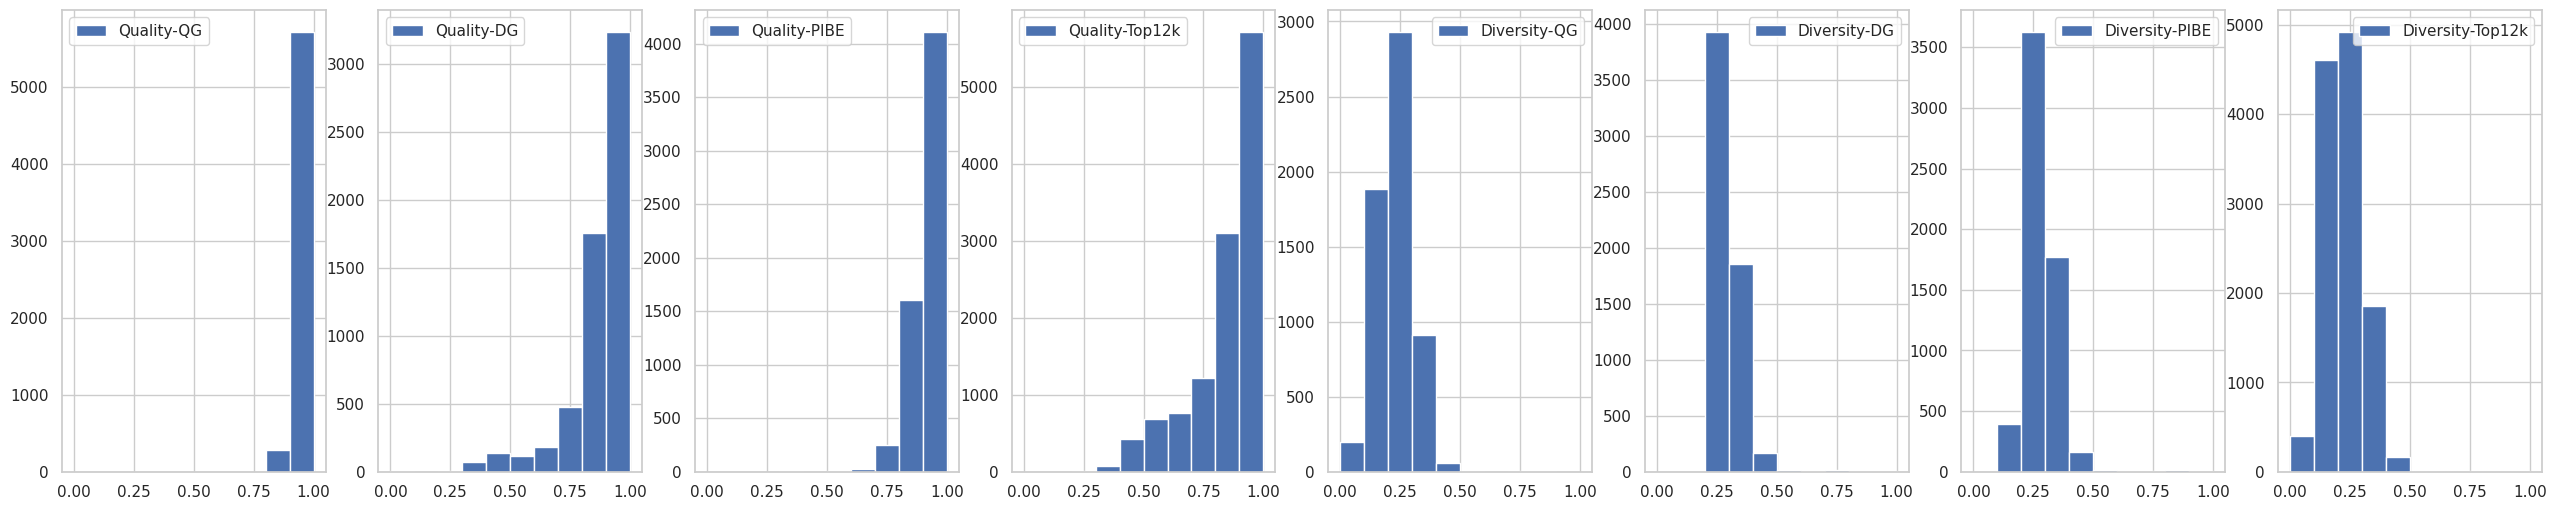

In [169]:
analysis("1223_cleaned_5sets_euclidean_nonlinear_v4_0.70_alpha_0.3_lamb_0.9_gamma_2.0")

# Quality Distribution

In [198]:
def quality_hist(name, is_baseline=False):
    if is_baseline:
        path = f"../baselines/{name}.pth"
    else:
        path = f"../pool_evolve/ap_outputs/{name}/WizardLM_alpaca.pth"
    data = torch.load(path)
    if type(data) is dict:
        data = data['data']
    quality = [item['quality'] for item in data]

    counts, bins, patches = plt.hist(np.array(quality), bins=[3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75])
    for count, patch in zip(counts, patches):
        if count ==  0:
            continue
        height = patch.get_height()
        plt.annotate(f'{int(count)}', 
                     xy=(patch.get_x() + patch.get_width() / 2, height), 
                     xytext=(0, 5),  # 5 points vertical offset
                     textcoords='offset points', 
                     ha='center', va='bottom')
    plt.show()

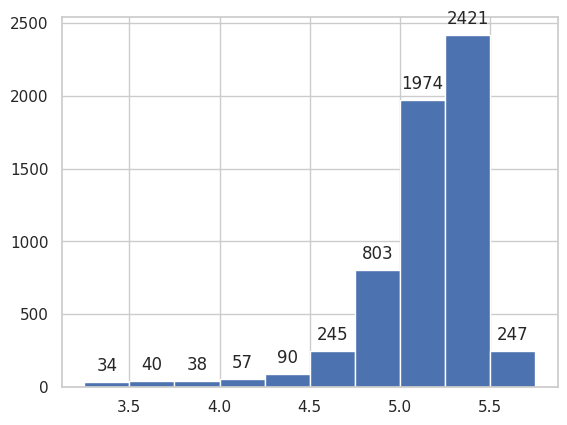

In [197]:
quality_hist("1205_cleaned_euclidean_multiply_alpha_0.3_lambda_0.9_gamma_1.0_6k")

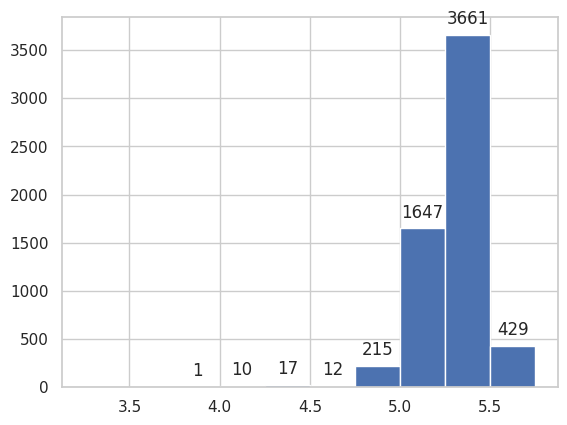

In [191]:
quality_hist("1205_cleaned_euclidean_multiply_alpha_0.3_lambda_0.9_gamma_2.0_6k")

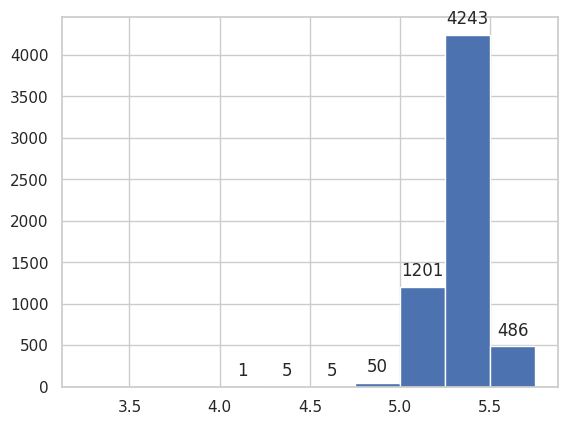

In [190]:
quality_hist("1217_cleaned_5sets_euclidean_multiply_alpha_0.3_lambda_0.9_gamma_3_6k")

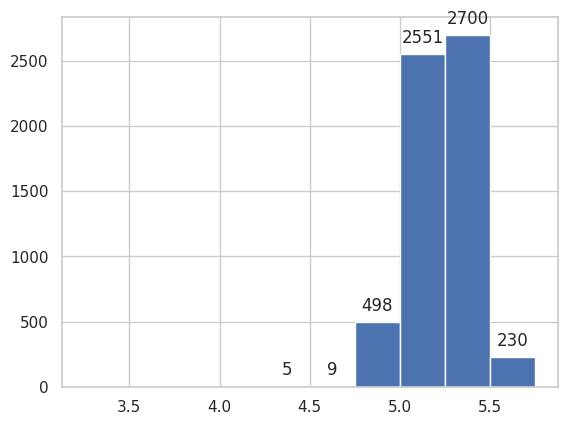

In [192]:
quality_hist("1223_cleaned_5sets_euclidean_nonlinear_v4_0.70_alpha_0.3_lambda_0.9_gamma_2.0_6k")

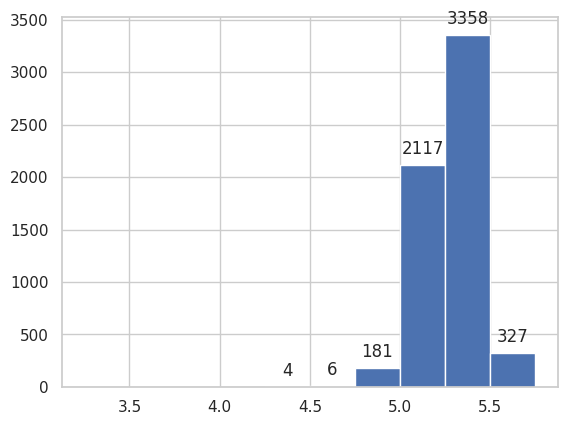

In [193]:
quality_hist("1223_cleaned_5sets_euclidean_nonlinear_v4_0.80_alpha_0.3_lambda_0.9_gamma_2.0_6k")

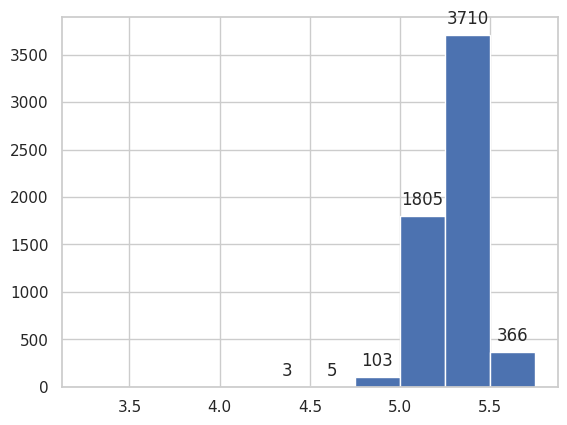

In [194]:
quality_hist("1223_cleaned_5sets_euclidean_nonlinear_v4_0.90_alpha_0.3_lambda_0.9_gamma_2.0_6k")

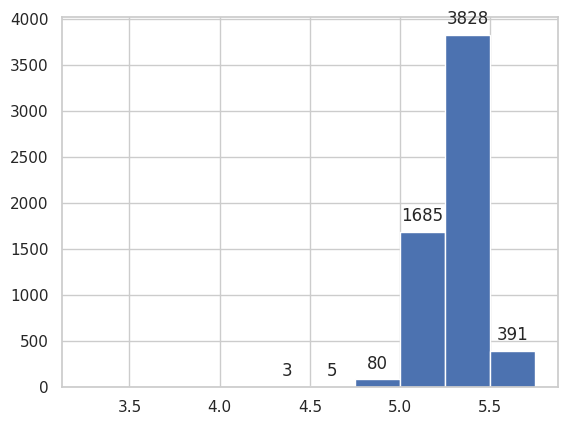

In [195]:
quality_hist("1223_cleaned_5sets_euclidean_nonlinear_v4_0.95_alpha_0.3_lambda_0.9_gamma_2.0_6k")

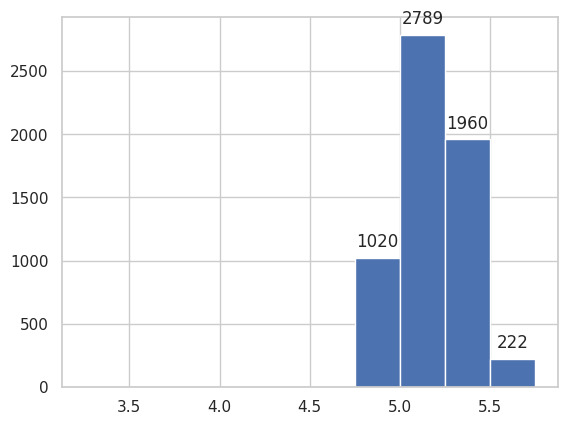

In [199]:
quality_hist("cleaned_no_complexity_deita_6k", is_baseline=True)

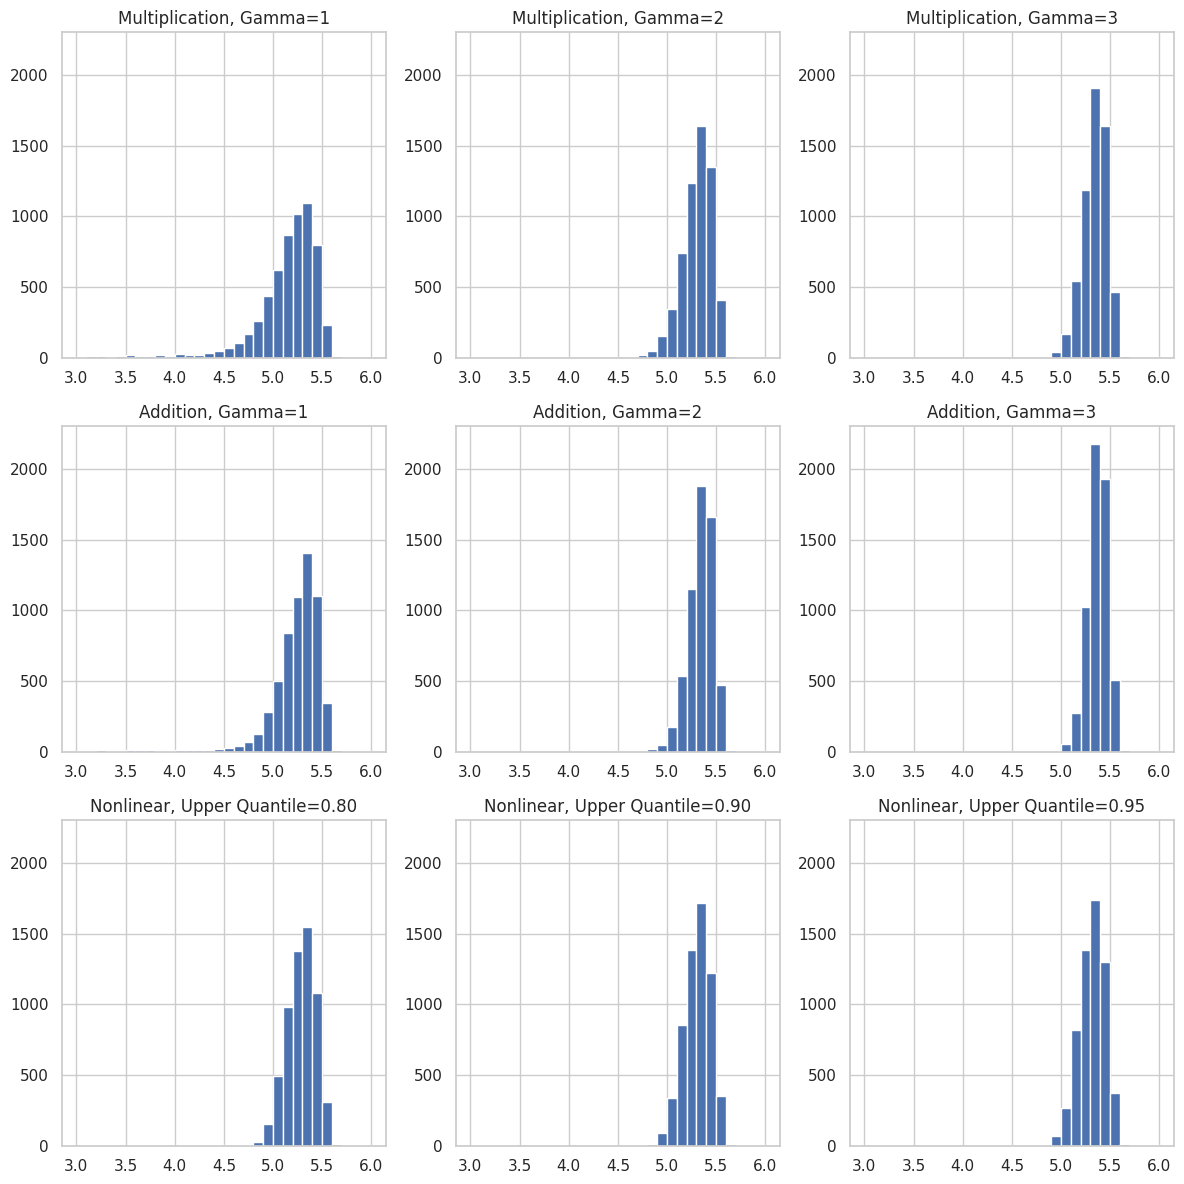

In [213]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

name_list = (
    "1205_cleaned_euclidean_multiply_alpha_0.3_lambda_0.9_gamma_1.0_6k",
    "1205_cleaned_euclidean_multiply_alpha_0.3_lambda_0.9_gamma_2.0_6k",
    "1217_cleaned_5sets_euclidean_multiply_alpha_0.3_lambda_0.9_gamma_3_6k",
    "1209_cleaned_euclidean_addition_alpha_0.3_lambda_0.9_gamma_1.0_6k",
    "1209_cleaned_euclidean_addition_alpha_0.3_lambda_0.9_gamma_2.0_6k",
    "1220_cleaned_5sets_euclidean_addition_alpha_0.3_lambda_0.9_gamma_3_6k",
    "1223_cleaned_5sets_euclidean_nonlinear_v4_0.80_alpha_0.3_lambda_0.9_gamma_2.0_6k",
    "1223_cleaned_5sets_euclidean_nonlinear_v4_0.90_alpha_0.3_lambda_0.9_gamma_2.0_6k",
    "1223_cleaned_5sets_euclidean_nonlinear_v4_0.95_alpha_0.3_lambda_0.9_gamma_2.0_6k"
)

title_list = (
    "Multiplication, Gamma=1",
    "Multiplication, Gamma=2",
    "Multiplication, Gamma=3",
    "Addition, Gamma=1",
    "Addition, Gamma=2",
    "Addition, Gamma=3",
    "Nonlinear, Upper Quantile=0.80",
    "Nonlinear, Upper Quantile=0.90",
    "Nonlinear, Upper Quantile=0.95",
)

for i, ax in enumerate(axes.flatten()):
    path = f"../pool_evolve/ap_outputs/{name_list[i]}/WizardLM_alpaca.pth"
    data = torch.load(path)
    if type(data) is dict:
        data = data['data']
    quality = [item['quality'] for item in data]
    min_val = 3.0
    max_val = 6.0
    number_of_bins = 30  # 可调整的 bin 数
    bins = np.linspace(min_val, max_val, number_of_bins + 1)
    
    counts, bins, patches = ax.hist(quality, bins=bins)
    ax.set_ylim(0, 2300)  # 设置y轴的值域
    ax.set_title(title_list[i])

# plt.suptitle('Quality Distribution')

# 调整子图之间的距离
plt.tight_layout()

plt.savefig("../analysis/selected_data_quality_distribution.pdf", format="pdf")

# 显示图
plt.show()